<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/new_drive')

Drive already mounted at /content/new_drive; to attempt to forcibly remount, call drive.mount("/content/new_drive", force_remount=True).


In [ ]:
train_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/train"
val_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/val"
test_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/test"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [ ]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 4

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.


In [ ]:
# Step 3: Build GoogleNet Model
def build_googlenet_model(input_shape=(224, 224, 3), num_classes=6):
    """Build a GoogleNet (InceptionV1) model for classification."""
    inputs = layers.Input(shape=input_shape)

    # Stem of GoogleNet
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception Modules
    def inception_module(x, filters):
        f1, f3r, f3, f5r, f5, proj = filters

        path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

        path2 = layers.Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
        path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

        path3 = layers.Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
        path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

        path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        path4 = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(path4)

        return layers.concatenate([path1, path2, path3, path4], axis=-1)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Build the model
model = build_googlenet_model()

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_228 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 56, 56, 64)     │              0 │ conv2d_228[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_229 (Conv2D)       │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_230 (Conv2D)       │ (None, 56, 56, 192)    │        110,784 │ conv2d_229[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_53          │ (None, 28, 28, 192)    │              0 │ conv2d_230[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_232 (Conv2D)       │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_53[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_234 (Conv2D)       │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_53[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_54          │ (None, 28, 28, 192)    │              0 │ max_pooling2d_53[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_231 (Conv2D)       │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_53[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_233 (Conv2D)       │ (None, 28, 28, 128)    │        110,720 │ conv2d_232[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_235 (Conv2D)       │ (None, 28, 28, 32)     │         12,832 │ conv2d_234[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_236 (Conv2D)       │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_54[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_36            │ (None, 28, 28, 256)    │              0 │ conv2d_231[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_233[0][0],      │
│                           │                        │                │ conv2d_235[0][0],      │
│                           │                        │                │ conv2d_236[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_238 (Conv2D)       │ (None, 28, 28, 128)    │         32,896 │ concatenate_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_240 (Conv2D)       │ (None, 28, 28, 32)     │          8,224 │ concatenate_36[0][0]   │
├──────────────────────

 Total params: 5,979,702 (22.81 MB)

 Trainable params: 5,979,702 (22.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 161s 823ms/step - accuracy: 0.3083 - loss: 1.7083 - val_accuracy: 0.3407 - val_loss: 1.6538
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.3338 - loss: 1.6322 - val_accuracy: 0.3407 - val_loss: 1.5704
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.3550 - loss: 1.5690 - val_accuracy: 0.3596 - val_loss: 1.4230
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.4017 - loss: 1.4256 - val_accuracy: 0.4511 - val_loss: 1.2821
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.4759 - loss: 1.3315 - val_accuracy: 0.4669 - val_loss: 1.3461
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.4578 - loss: 1.2948 - val_accuracy: 0.4700 - val_loss: 1.2154
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5105 - loss: 1.2105 - val_accuracy: 0.5268 - val_loss: 1.1538
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5091 - loss: 1.1572 - val_

In [ ]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

    class_mode='categorical'
)

Found 222 images belonging to 6 classes.


In [ ]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 638ms/step - accuracy: 0.9732 - loss: 0.0849
Test Accuracy: 95.95%


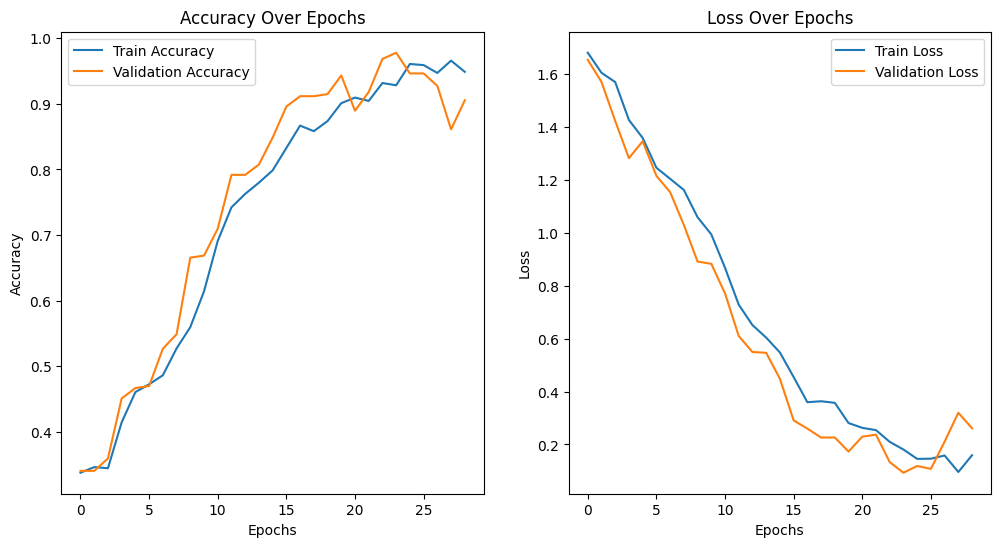

In [ ]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Save the model
model.save("SegNet.h5")
print("Model saved.")